In [1]:
from pathlib import Path
import os 
import sys
import numpy as np
import json

root = Path().resolve().parent

root_str = str(root)
if root_str not in sys.path:
    sys.path.insert(0, root_str)

if Path.cwd() != root:
    os.chdir(root)
    
from importlib import reload

## Rotowire

In [21]:
from jsonschema import Draft7Validator
from typing import Any, Dict, List, Tuple

def _ok(value: Any, allowed_types) -> bool:
    """Helper function to check key-wise type."""
    if not isinstance(allowed_types, list):
        allowed_types = [allowed_types]
    return (
        (value is None and "null" in allowed_types) or
        (isinstance(value, int)  and "integer" in allowed_types) or
        (isinstance(value, str)  and "string"  in allowed_types)
    )

def _score_section(data: List[Dict[str, Any]] | None,
                   definition: Dict[str, Any],
                   min_items: int | None,
                   max_items: int | None) -> Tuple[int, int]:
    """
    Returns (valid, total) for the section.
    If data is None (missing) or length violates min/max, returns (0, 1) → 0 %.
    """
    if data is None:
        return 0, 1                              # missing section → 0 %
    if (min_items and len(data) < min_items) or \
       (max_items and len(data) > max_items):
        return 0, 1                              # length violation → 0 %

    props     = definition["properties"]
    required  = set(definition.get("required", []))
    allow_add = definition.get("additionalProperties", False)

    total = valid = 0
    for obj in data:
        # Required keys first
        for key in required:
            total += 1
            if key in obj and _ok(obj[key], props[key]["type"]):
                valid += 1
                
        # Then looking at the other ones
        for key, val in obj.items():
            if key in required:
                continue
            total += 1
            if key in props:
                if _ok(val, props[key]["type"]):
                    valid += 1
            elif allow_add:
                valid += 1                        # Allowed extras
            # else: extra - invalid (counts as 0)

    return valid, total if total else (0,1)       # avoid div-by-zero

def compliance_breakdown(schema: Dict[str, Any],
                         record: Dict[str, Any]) -> Dict[str, float]:
    """Percentage compliance + real Draft-07 errors, handles all edge-cases."""
    validator = Draft7Validator(schema)
    errors    = list(validator.iter_errors(record))

    # Pull defs & array length rules from the schema
    team_def   = schema["definitions"]["team"]
    player_def = schema["definitions"]["player"]

    teams_schema   = schema["items"]["properties"]["teams"]
    players_schema = schema["items"]["properties"]["players"]

    t_valid, t_total = _score_section(
        record.get("teams"),
        team_def,
        teams_schema.get("minItems"),
        teams_schema.get("maxItems")
    )
    p_valid, p_total = _score_section(
        record.get("players"),
        player_def,
        players_schema.get("minItems"),
        players_schema.get("maxItems")
    )

    team_compliance = t_valid / t_total
    player_compliance = p_valid / p_total

    return {
        "team_compliance_%":   team_compliance * 100,
        "player_compliance_%": player_compliance * 100,
        "overall_compliance_%": float(np.mean([team_compliance, player_compliance])) * 100,
        "errors": errors
    }


In [ ]:
path = "data/clean/rotowire/"

# Example usage:
with open(path + "schema.json") as sf, open(path + "clean.json") as rf:
    schema = json.load(sf)
    record = json.load(rf)[0]["output"]

result = compliance_breakdown(schema, record)
print(f"Teams:  {result['team_compliance_%']:.1f}%")
print(f"Players:{result['player_compliance_%']:.1f}%")
print(f"Overall:{result['overall_compliance_%']:.1f}%")
for err in result["errors"]:
    print(f"– {err.message} (at {list(err.absolute_path)})")
print(result)

Teams:  100.0%
Players:100.0%
Overall:100.0%
{'team_compliance_%': 100.0, 'player_compliance_%': 100.0, 'overall_compliance_%': 100.0, 'errors': []}


In [4]:
record

{'teams': [{'team': 'Suns', 'losses': 38, 'total_points': 87, 'wins': 39},
  {'team': 'Jazz', 'losses': 42, 'total_points': 85, 'wins': 34}],
 'players': [{'player': 'Gordon Hayward',
   'assists': None,
   'blocks': None,
   '3_pointers_made': None,
   'field_goals_attempted': 18,
   'minutes_played': None,
   'points': 21,
   'total_rebounds': None,
   'steals': None},
  {'player': 'Rudy Gobert',
   'assists': 2,
   'blocks': 1,
   '3_pointers_made': None,
   'field_goals_attempted': None,
   'minutes_played': 38,
   'points': 8,
   'total_rebounds': 15,
   'steals': 1},
  {'player': 'Rodney Hood',
   'assists': None,
   'blocks': None,
   '3_pointers_made': None,
   'field_goals_attempted': None,
   'minutes_played': None,
   'points': 17,
   'total_rebounds': None,
   'steals': None},
  {'player': 'Brandan Wright',
   'assists': 1,
   'blocks': 4,
   '3_pointers_made': None,
   'field_goals_attempted': None,
   'minutes_played': 33,
   'points': 14,
   'total_rebounds': 3,
   'stea

In [21]:
reload(src.evaluate)
from src.evaluate import RotowireEvaluator

eval = RotowireEvaluator(schema)

eval.compliance_breakdown(json.dumps(record))

{'is_valid': 1,
 'team_compliance_%': 1.0,
 'player_compliance_%': 1.0,
 'overall_compliance_%': 1.0,
 'errors': []}

In [22]:
eval.compliance_breakdown(str(record))

{'is_valid': 0,
 'team_compliance_%': 1.0,
 'player_compliance_%': 0.46296296296296297,
 'overall_compliance_%': 0.7314814814814815,
 'errors': []}

In [23]:
record_2 = """{'teams': [{'team': 'Suns', 'losses': 38, 'total_points': 87, 'wins': 39},
  {'team': 'Jazz', 'losses': 42, 'total_points': 85, 'wins': 34}],
 'players': [{'player': 'Gordon Hayward',
   'assists': null,
   'blocks': null,
   '3_pointers_made': null,
   'field_goals_attempted': 18,
   'minutes_played': null,
   'points': 21,
   'total_rebounds': null,
   'steals': null},
  {'player': 'Rudy Gobert',
   'assists': 2,
   'blocks': 1,
   '3_pointers_made': null,
   'field_goals_attempted': null,
   'minutes_played': 38,
   'points': 8,
   'total_rebounds': 15,
   'steals': 1},
  {'player': 'Rodney Hood',
   'assists': null,
   'blocks': null,
   '3_pointers_made': null,
   'field_goals_attempted': null,
   'minutes_played': null,
   'points': 17,
   'total_rebounds': null,
   'steals': null},
  {'player': 'Brandan Wright',
   'assists': 1,
   'blocks': 4,
   '3_pointers_made': null,
   'field_goals_attempted': null,
   'minutes_played': 33,
   'points': 14,
   'total_rebounds': 3,
   'steals': 3},
  {'player': 15,
   'assists': null,
   'blocks': null,
   '3_pointers_made': null,
   'field_goals_attempted': null,
   'minutes_played': null,
   'points': 4,
   'total_rebounds': null,
   'steals': null},
  {'player': 'Gerald Green',
   'assists': null,
   'blocks': null,
   '3_pointers_made': 3,
   'field_goals_attempted': null,
   'minutes_played': 22,
   'points': 24,
   'total_rebounds': null,
   'ste;als': null}}"""
   
eval.compliance_breakdown(record_2)

{'is_valid': 0,
 'team_compliance_%': 1.0,
 'player_compliance_%': 0.9629629629629629,
 'overall_compliance_%': 0.9814814814814814,
 'errors': []}

In [24]:
eval.evaluate_game(record, record)

{'ident_f1': 1.0,
 'object_attr_F1': 1.0,
 'object_value_acc': 1.0,
 'object_attribute_score': 1.0,
 'overall_score': 1.0}

In [11]:
record

{'teams': [{'team': 'Suns', 'losses': 38, 'total_points': 87, 'wins': 39},
  {'team': 'Jazz', 'losses': 42, 'total_points': 85, 'wins': 34}],
 'players': [{'player': 'Gordon Hayward',
   'assists': None,
   'blocks': None,
   '3_pointers_made': None,
   'field_goals_attempted': 18,
   'minutes_played': None,
   'points': 21,
   'total_rebounds': None,
   'steals': None},
  {'player': 'Rudy Gobert',
   'assists': 2,
   'blocks': 1,
   '3_pointers_made': None,
   'field_goals_attempted': None,
   'minutes_played': 38,
   'points': 8,
   'total_rebounds': 15,
   'steals': 1},
  {'player': 'Rodney Hood',
   'assists': None,
   'blocks': None,
   '3_pointers_made': None,
   'field_goals_attempted': None,
   'minutes_played': None,
   'points': 17,
   'total_rebounds': None,
   'steals': None},
  {'player': 'Brandan Wright',
   'assists': 1,
   'blocks': 4,
   '3_pointers_made': None,
   'field_goals_attempted': None,
   'minutes_played': 33,
   'points': 14,
   'total_rebounds': 3,
   'stea

### Another trial

In [24]:
from jsonschema import Draft7Validator
from typing import Any, Iterable, Mapping

# ── A ── count how many *primitive* checks a schema implies ────────────
def _leaf_count(schema: Mapping[str, Any]) -> int:
    t = schema.get("type")

    if t == "object":
        return sum(_leaf_count(s) for s in schema.get("properties", {}).values())
    if t == "array":
        return 1 + _leaf_count(schema.get("items", {}))          # 1 for the array itself
    return 1                                                     # scalar / “primitive”


# ── B ── resolve a JSON-Pointer (RFC 6901) inside *schema* ─────────────
def resolve_pointer(schema: Mapping[str, Any], pointer: str) -> Mapping[str, Any]:
    """
    Return the subschema addressed by *pointer* (e.g. "#/definitions/player").
    Accepts both absolute "#/…" and plain "/…" forms.
    """
    if pointer.startswith("#"):
        pointer = pointer[1:]
    if pointer.startswith("/"):
        pointer = pointer[1:]

    node: Mapping[str, Any] = schema
    for token in pointer.split("/"):
        # unescape
        token = token.replace("~1", "/").replace("~0", "~")
        node = node[token]
    return node


# ── C ── score data against *any* (sub)schema ──────────────────────────
def score_against_schema(schema: Mapping[str, Any], data: Any) -> dict:
    """
    Return {"percentage": float, "failures": list[ValidationError]}.
    """
    v = Draft7Validator(schema)
    errors = list(v.iter_errors(data))
    total_checks = _leaf_count(schema)
    pct = round(100 * (total_checks - len(errors)) / total_checks, 1) if total_checks else 100.0
    return {"percentage": pct, "failures": errors}

def score_collection(root_schema: Mapping[str, Any],
                     record: Mapping[str, Any],
                     collection_prop: str,
                     subschema_pointer: str) -> list[dict]:
    """
    • *collection_prop*        name of the property in *record*
    • *subschema_pointer*      JSON-Pointer to the element schema
    Returns a list with one report per element.
    """
    subschema = resolve_pointer(root_schema, subschema_pointer)
    collection: Iterable[Any] = record.get(collection_prop, [])
    return [score_against_schema(subschema, item) for item in collection]


root_schema = json.loads(open(r"data\clean\rotowire\schema.json").read())  # your Draft-7 file
with open(r"data\clean\rotowire\bench.json") as rf:
    record = json.load(rf)

game = record[0]["output"]
# Whole-record score (optional)
overall = score_against_schema(root_schema, game)
print("Overall:", overall["percentage"], "% valid")

# Per-team
team_reports = score_collection(root_schema, game,
                                collection_prop="teams",
                                subschema_pointer="#/definitions/team")

# Per-player
player_reports = score_collection(root_schema, game,
                                  collection_prop="players",
                                  subschema_pointer="#/definitions/player")

# Pretty-print
for i, rep in enumerate(team_reports, 1):
    print(f"Team {i}: {rep['percentage']} % valid")
for i, rep in enumerate(player_reports, 1):
    print(f"Player {i}: {rep['percentage']} % valid")



Overall: 100.0 % valid
Team 1: 100.0 % valid
Team 2: 100.0 % valid
Player 1: 100.0 % valid
Player 2: 100.0 % valid
Player 3: 100.0 % valid
Player 4: 100.0 % valid
Player 5: 100.0 % valid
Player 6: 100.0 % valid
Player 7: 100.0 % valid


## Wikibio

In [2]:
from src.evaluate import GeneralJsonSchemaEvaluator

with open(r"data\clean\2-wiki_bio\bench.json", "r") as f:
    data = json.load(f)
    
i = 23

validator = GeneralJsonSchemaEvaluator(data[i]["schema"])
validator.score_against_schema(data[i]["output"])

{'compliance': 1.0, 'compliance_errors': []}

In [3]:
output = {'occupation': 'television/film director, producer',
 'years_active': '19512009',
 'name': 'john rich',
 'death_phlace': 'los angeles, california, u.s.',
 'birth_place': 'rockaway beach, new york, u.s.',
 'death_date': '2012-01-295',
 'alma_mater': 'university of michigan',
 'birth_date': '1925-067'}

validator.score_against_schema(output)

{'compliance': 0.4,
 'compliance_errors': [<ValidationError: "'article_title' is a required property">,
  <ValidationError: "'death_place' is a required property">,
  <ValidationError: "'1925-067' does not match '^\\\\d{4}(-\\\\d{2}){0,1}(-\\\\d{2}){0,1}$'">,
  <ValidationError: "'2012-01-295' does not match '^\\\\d{4}(-\\\\d{2}){0,1}(-\\\\d{2}){0,1}$'">,
  <ValidationError: "Additional properties are not allowed ('death_phlace' was unexpected)">]}

In [4]:
from src.evaluate import WikiBioEvaluator

assessor = WikiBioEvaluator()
print(assessor.compute_compliance(json.dumps(output), data[i]["schema"]))
print(assessor.compute_correctness(data[i], {"output": output}))

{'is_valid': 1, 'compliance': 0.4, 'compliance_errors': [<ValidationError: "'article_title' is a required property">, <ValidationError: "'death_place' is a required property">, <ValidationError: "'1925-067' does not match '^\\\\d{4}(-\\\\d{2}){0,1}(-\\\\d{2}){0,1}$'">, <ValidationError: "'2012-01-295' does not match '^\\\\d{4}(-\\\\d{2}){0,1}(-\\\\d{2}){0,1}$'">, <ValidationError: "Additional properties are not allowed ('death_phlace' was unexpected)">]}
{'overall_score': 1.0, 'correctness_errors': []}


In [5]:
data[i]["output"]

{'occupation': 'television/film director, producer',
 'article_title': 'john rich (director)',
 'years_active': '19512009',
 'name': 'john rich',
 'death_place': 'los angeles, california, u.s.',
 'birth_place': 'rockaway beach, new york, u.s.',
 'death_date': '2012-01-29',
 'alma_mater': 'university of michigan',
 'birth_date': '1925-07'}

## Few nerds

In [11]:
with open(r"data\clean\3-few_nerd\parsed.json", "r") as f, open(r"data\clean\3-few_nerd\schema.json", "r") as sf:
    data = json.load(f)
    schema = json.load(sf)
    
data[43]

{'input': "Argentina 's Del Imaginario Discos also released the album in 2007 .",
 'output': {'art': None,
  'building': None,
  'event': None,
  'location': ['Argentina'],
  'organization': ['Del Imaginario Discos'],
  'other': None,
  'person': None,
  'product': None}}

In [12]:
from src.evaluate import GeneralJsonSchemaEvaluator
assessor = GeneralJsonSchemaEvaluator(schema)

assessor.score_against_schema(data[43]["output"])

{'compliance': 1.0, 'compliance_errors': []}

In [13]:
output = {'input': "Argentina 's Del Imaginario Discos also released the album in 2007 .",
 'output': {'art': None,
  'building': [],
  'event': [12],
  'location': ['Argentina'],
  'organization': ['Del Imaginario Discos'],
  'other': None,
  'product': "you",
  "him": None}}

assessor.score_against_schema(output["output"])


{'compliance': 0.4,
 'compliance_errors': [<ValidationError: "Additional properties are not allowed ('him' was unexpected)">,
  <ValidationError: "'person' is a required property">,
  <ValidationError: '[] should be non-empty'>,
  <ValidationError: "12 is not of type 'string'">,
  <ValidationError: "'you' is not of type 'array', 'null'">]}

In [14]:
import src.evaluate
reload(src.evaluate)
from src.evaluate import FewNerdsEvaluator

assessor_2 = FewNerdsEvaluator()
print(assessor_2.compute_compliance(data[43]["output"]))
print(assessor_2.compute_correctness(data[43]["output"], data[43]["output"]))

{'compliance': 1.0, 'compliance_errors': []}
{'overall_score': 1.0, 'correctness_errors': []}


In [15]:
print(assessor_2.compute_compliance(output["output"]))
print(assessor_2.compute_correctness(data[43]["output"], output["output"]))

{'compliance': 0.4, 'compliance_errors': [<ValidationError: "Additional properties are not allowed ('him' was unexpected)">, <ValidationError: "'person' is a required property">, <ValidationError: '[] should be non-empty'>, <ValidationError: "12 is not of type 'string'">, <ValidationError: "'you' is not of type 'array', 'null'">]}
{'overall_score': 0.5, 'correctness_errors': ["Spurious event: ['12']", "Spurious product: ['you']"]}


### Subset

In [37]:
ordered_clean_data = []
for i, record in enumerate(data):
    record["id"] = i
    ordered_clean_data.append({k: record[k] for k in sorted(record)})

with open(r"data\clean\3-few_nerd\clean.json", "w") as f:
    json.dump(ordered_clean_data, f, indent=2)

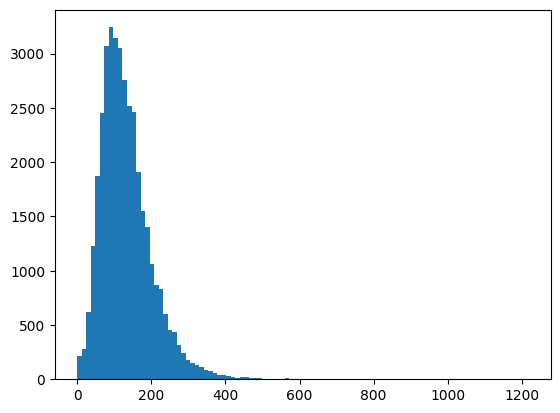

In [38]:
import matplotlib.pyplot as plt
length = []
for record in ordered_clean_data:
    length.append(len(record["input"]))

length = np.array(length)
plt.hist(length, bins=100);


In [46]:
subset = np.random.choice(np.array(ordered_clean_data)[length > 100], 100, replace=False).tolist()
subset

[{'id': 16119,
  'input': "The mission of the 303rd Military Intelligence Battalion , `` Longhorns , '' is to , on order , conduct multi-disciplined intelligence collection , exploitation , and limited analysis operations in support of the commander 's information requirements during worldwide contingency missions within assigned areas of a Division , Corps , or Joint Task Force area of operations .",
  'output': {'art': None,
   'building': None,
   'event': None,
   'location': None,
   'organization': ['303rd Military Intelligence Battalion', 'Longhorns'],
   'other': None,
   'person': None,
   'product': None}},
 {'id': 29924,
  'input': 'This was officially launched in a ceremony at the Genting Highlands Fire and Rescue Station in Pahang on 21 February 1997 , by Prime Minister of Malaysia Mahathir Mohamad .',
  'output': {'art': None,
   'building': None,
   'event': None,
   'location': ['Pahang', 'Malaysia'],
   'organization': ['Genting Highlands Fire', 'Rescue Station'],
   '

In [47]:
with open(r"data\clean\3-few_nerd\bench.json", "w") as f:
    json.dump(subset, f, indent=2)

In [48]:
subset[:5]

[{'id': 16119,
  'input': "The mission of the 303rd Military Intelligence Battalion , `` Longhorns , '' is to , on order , conduct multi-disciplined intelligence collection , exploitation , and limited analysis operations in support of the commander 's information requirements during worldwide contingency missions within assigned areas of a Division , Corps , or Joint Task Force area of operations .",
  'output': {'art': None,
   'building': None,
   'event': None,
   'location': None,
   'organization': ['303rd Military Intelligence Battalion', 'Longhorns'],
   'other': None,
   'person': None,
   'product': None}},
 {'id': 29924,
  'input': 'This was officially launched in a ceremony at the Genting Highlands Fire and Rescue Station in Pahang on 21 February 1997 , by Prime Minister of Malaysia Mahathir Mohamad .',
  'output': {'art': None,
   'building': None,
   'event': None,
   'location': ['Pahang', 'Malaysia'],
   'organization': ['Genting Highlands Fire', 'Rescue Station'],
   '

## Top v1

In [17]:
import src

with open(r"data\clean\4-TOPv1\clean.json", "r") as f, open(r"data\clean\4-TOPv1\schema.json", "r") as sf:
    data = json.load(f)
    schema = json.load(sf)
    
reload(src.evaluate)
from src.evaluate import GeneralJsonSchemaEvaluator
evaluator = GeneralJsonSchemaEvaluator(schema)

In [ ]:
errors = []
for i, record in enumerate(data):
    score = evaluator.score_against_schema(record["output"])
    if score["compliance"] < 1.0:
        print(i)
        print(record)
        print(score)
        print()
        errors.append((i, score["compliance"], record["output"]))

In [18]:
record = {'intent': 'GET_EVENT',
 'slots': {'NAME_EVENT': 'Kanye West',
  'CATEGORY_EVENT': 'concerts',
  'DATE_TIME': 'this year'}}
evaluator.score_against_schema(record)

{'compliance': 1.0, 'compliance_errors': []}

In [19]:
from src.evaluate import TopV1Evaluator

validator = TopV1Evaluator()
for i, record in enumerate(data):
    score = validator.compute_compliance(record["output"])
    if score["compliance"] < 1.0:
        print(i)
        print(record)
        print(score)
        print()
        errors.append((i, score, record["output"]))

In [23]:
from pprint import pprint

pprint(data[5678]["output"])

{'intent': 'GET_INFO_TRAFFIC',
 'slots': {'LOCATION': {'intent': 'GET_LOCATION',
                        'slots': {'LOCATION_MODIFIER': 'nearby'}}}}


In [40]:
test = {'intent': 'GET_INFO_TRAFFIC',
 'slots': {'LOCATION': {'intent': 'GET_LOCATHION',
                        'slots': {'LOCATION_MODIFIER': 'around'}}}}

validator.compute_correctness(data[5678]["output"], test)

{'correctness': 0.75, 'correctness_errors': ['tree-triplet F1=0.50']}

In [42]:
subset = np.random.choice(data, 150, replace=False).tolist()
subset

[{'id': 4758,
  'input': 'Where are the active photo radar cameras in the 10 mile radius around my house',
  'output': {'intent': 'UNSUPPORTED_NAVIGATION', 'slots': {}}},
 {'id': 8303,
  'input': 'what is the traffic on the belt',
  'output': {'intent': 'GET_INFO_TRAFFIC', 'slots': {'LOCATION': 'the belt'}}},
 {'id': 2766,
  'input': 'Bon Iver concerts this weekend near me',
  'output': {'intent': 'GET_EVENT',
   'slots': {'NAME_EVENT': 'Bon Iver',
    'CATEGORY_EVENT': 'concerts',
    'DATE_TIME': 'this weekend',
    'LOCATION': {'intent': 'GET_LOCATION',
     'slots': {'SEARCH_RADIUS': 'near', 'LOCATION_USER': 'me'}}}}},
 {'id': 150,
  'input': "I'm looking for a Broadway show for tomorrow afternoon",
  'output': {'intent': 'GET_EVENT',
   'slots': {'CATEGORY_EVENT': 'a Broadway show',
    'DATE_TIME': 'for tomorrow afternoon'}}},
 {'id': 3712,
  'input': 'Are there any traffic problems between here and home this afternoon?',
  'output': {'intent': 'GET_INFO_TRAFFIC',
   'slots': {'S

In [43]:
json.dump(subset, open(r"data\clean\4-TOPv1\bench.json", "w"), indent=2)

# API BANK

In [89]:
data = json.load(open(r"data\clean\5-api_bank\parsed.json"))
pprint(data[7])

{'id': 7,
 'input': 'User: Can you help me find out about shortness of breath?\n'
          'AI: Sure, I can call the EmergencyKnowledge API to search for '
          'information about shortness of breath.\n'
          'API-Request: '
          '{"api_name":"EmergencyKnowledge","parameters":{"symptom":"shortness '
          'of breath"}}->[{\'name\': \'Asthma\', \'aid\': \'Treatment may '
          'involve inhalers or nebulizers to open the airways, as well as '
          "medications to manage inflammation and prevent attacks.'}, {'name': "
          "'Pneumonia', 'aid': 'Treatment may involve antibiotics, rest, and "
          "fluids to help the body fight the infection and recover.'}]\n"
          'AI: Here are some possible diseases related to shortness of breath: '
          'Asthma and Pneumonia. Would you like me to provide more '
          'information?\n'
          'User: Yes, please.\n'
          'AI: For Asthma, it is a chronic respiratory condition characterized '
      

In [115]:
import json, re

TYPE_MAP = {
    "str":   "string",
    "string":"string",
    "int":   "integer",
    "integer":"integer",
    "float": "number",
    "double":"number",
    "number":"number",
    "bool":  "boolean",
    "boolean":"boolean",
    "list":  "array",            # plain “list”
}

LIST_RE = re.compile(r"list\(\s*(\w+)\s*\)", re.I)

# ------------------------------------------------------------------
# 0️⃣ Tiny utility: turn a strftime-style format into a JSON-Schema regex
# (handles just the two formats that appear in API-Bank; add more as needed)
# ------------------------------------------------------------------
DATE_REGEXES = {
    "%Y-%m-%d"            : r"^\d{4}-\d{2}-\d{2}$",
    "%Y-%m-%d %H:%M:%S"   : r"^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$",
}

def regex_from_description(desc: str):
    m = re.search(r"Format:\s*([%YmdHMS\-\s:]+)", desc)
    if not m:
        return None
    fmt = m.group(1).strip()
    return DATE_REGEXES.get(fmt)


# ------------------------------------------------------------------
# 1️⃣  Balanced-brace extractor (unchanged)
# ------------------------------------------------------------------
def extract_api_jsons(text: str):
    objs, depth, start = [], 0, None
    in_string = escape = False

    for i, ch in enumerate(text):
        if ch == '"' and not escape:
            in_string = not in_string
        escape = (ch == '\\' and not escape)
        if in_string:
            continue

        if ch == '{':
            if depth == 0:
                start = i
            depth += 1
        elif ch == '}':
            depth -= 1
            if depth == 0 and start is not None:
                candidate = text[start:i+1]
                if '"name"' in candidate and '"input_parameters"' in candidate:
                    try:
                        objs.append(json.loads(candidate))
                    except json.JSONDecodeError:
                        pass
    return objs


# ------------------------------------------------------------------
# 2️⃣  Build the param-object subschema (now with optional "pattern")
# ------------------------------------------------------------------
def build_param_schema(param_dict):
    props = {}
    for name, spec in param_dict.items():
        raw_type = spec.get("type", "").strip().lower()

        # 1. map scalar types
        jstype   = TYPE_MAP.get(raw_type)

        # 2. handle list(…) special form
        if jstype is None:
            m = LIST_RE.fullmatch(raw_type)
            if m:
                inner = TYPE_MAP.get(m.group(1).lower(), "string")
                jstype = "array"
                props[name] = {
                    "type" : "array",
                    "items": {"type": inner},
                }
            else:                       # unknown -> fallback string
                jstype = "string"

        # 3. normal scalar field
        if name not in props:
            props[name] = {"type": jstype}

        # 4. optional date-pattern
        if pat := regex_from_description(spec.get("description", "")):
            props[name]["pattern"] = pat

    return {
        "type"                : "object",
        "required"            : list(param_dict),         
        "additionalProperties": False,
        "properties"          : props,
    }


# ------------------------------------------------------------------
# 3️⃣  Build an individual API subschema (unchanged except it calls 2️⃣)
# ------------------------------------------------------------------
def build_api_subschema(api):
    return {
        "type"                : "object",
        "required"            : ["api_name", "parameters"],
        "additionalProperties": False,
        "properties"          : {
            "api_name"  : {"const": api["name"]},
            "parameters": build_param_schema(api["input_parameters"]),
        },
    }


# ------------------------------------------------------------------
# 4️⃣  Public helper to create the per-record JSON Schema
# ------------------------------------------------------------------
def make_record_schema(instruction: str) -> dict:
    apis        = extract_api_jsons(instruction)
    subschemas  = [build_api_subschema(api) for api in apis]

    return {
        "$schema": "https://json-schema.org/draft/2020-12/schema",
        "oneOf"  : subschemas,
    }

# example
record_schema = make_record_schema(data[19]["instruction"])
pprint(json.dumps(record_schema, indent=2))


('{\n'
 '  "$schema": "https://json-schema.org/draft/2020-12/schema",\n'
 '  "oneOf": [\n'
 '    {\n'
 '      "type": "object",\n'
 '      "required": [\n'
 '        "api_name",\n'
 '        "parameters"\n'
 '      ],\n'
 '      "additionalProperties": false,\n'
 '      "properties": {\n'
 '        "api_name": {\n'
 '          "const": "QueryMeeting"\n'
 '        },\n'
 '        "parameters": {\n'
 '          "type": "object",\n'
 '          "required": [\n'
 '            "token",\n'
 '            "meeting_topic",\n'
 '            "start_time",\n'
 '            "end_time",\n'
 '            "location",\n'
 '            "attendees"\n'
 '          ],\n'
 '          "additionalProperties": false,\n'
 '          "properties": {\n'
 '            "token": {\n'
 '              "type": "string"\n'
 '            },\n'
 '            "meeting_topic": {\n'
 '              "type": "string"\n'
 '            },\n'
 '            "start_time": {\n'
 '              "type": "string"\n'
 '            },\n'

In [116]:
import hashlib, json

def row_fingerprint(row):
    # hash whatever makes a record unique for you
    blob = json.dumps({
        "input": row["input"],
        "instruction": row["instruction"],
        "output": row["output"],
    }, sort_keys=True).encode()
    return hashlib.sha1(blob).hexdigest()

seen, unique_rows, dups = {}, [], []
for r in data:                                # ← your list of dicts
    fp = row_fingerprint(r)
    (dups if fp in seen else unique_rows).append(r)
    seen.setdefault(fp, r["id"])              # remember first id
    
for r in unique_rows:
    r["json_schema"] = make_record_schema(r["instruction"]) 


In [117]:
len(unique_rows), len(data)

(507, 534)

In [118]:
json.dump(unique_rows, open(r"data\clean\5-api_bank\clean.json", "w"), indent=2)

### Subset

In [119]:
data[19]

{'output': '{"api_name":"QueryMeeting","parameters":{"token":"a9s8d7f6g5h4j3k2l1","meeting_topic":"Sales Meeting","start_time":"2023-03-20 14:00:00","end_time":"2023-03-20 16:00:00","location":"Conference Room A","attendees":["John Smith","Jane Doe"]}}',
 'id': 19,
 'input': 'User: Can you help me check a meeting on March 20th from 2pm to 4pm in Conference Room A with John Smith and Jane Doe?\nAI: Sure, I can help with that. Do you have a meeting topic in mind?\nUser: Oh, yes. The meeting topic is Sales Meeting.\nAI: Great. To schedule the meeting, I need your username and password for authentication. Can you please provide that?\nUser: My username is JohnDoe and my password is pass123.\nAI: Thank you. Now, I need to get the user token for authentication.\nAPI-Request: {"api_name":"GetUserToken","parameters":{"username":"JohnDoe","password":"pass123"}}->{\'token\': \'a9s8d7f6g5h4j3k2l1\'}\nAI: Alright, I got the token. Now, I\'ll check your meeting.\nGenerate API Request:\n',
 'instruc

In [122]:
reload(src.evaluate)
from src.evaluate import GeneralJsonSchemaEvaluator
pb = []
clean = []

for r in unique_rows:
    evaluator = GeneralJsonSchemaEvaluator(r["json_schema"])
    score = evaluator.score_against_schema(json.loads(r["output"]))
    if score["compliance"] < 1.0:
        pb.append((r["id"], score, r))
        print(r["id"], score)
        pprint(r)
        print()
    else:
        clean.append(r)

35 {'compliance': 0.5, 'compliance_errors': [<ValidationError: "{'api_name': 'ForgotPassword', 'parameters': {'status': 'Forgot Password', 'username': 'foo', 'email': 'foo@example.com'}} is not valid under any of the given schemas">]}
{'id': 35,
 'input': 'User: I forgot my password, can you help me reset it?\n'
          'AI: Sure, I can definitely help you. I need your username and email '
          'to get started.\n'
          'User: My username is foo and my email is foo@example.com.\n'
          'AI: Alright.\n'
          'Generate API Request:\n',
 'instruction': '\n'
                'Generate an API request in the format of '
                '{"api_name":"ApiName","parameters":{"key1":"value1","key2":"value2"}} '
                'based on the previous dialogue context.\n'
                'The current year is 2023.\n'
                'Input: \n'
                "User: User's utterence\n"
                "AI: AI's response\n"
                '\n'
                'Expected output:

In [123]:
len(pb)

99

In [183]:
clean_2 = []

for record in clean:
    clean_2.append({
        "id": record["id"],
        "input": record["input"],
        "instruction": record["instruction"],
        "output": json.loads(record["output"]),
        "json_schema": record["json_schema"]
    })


json.dump(clean_2, open(r"data\clean\5-api_bank\clean.json", "w"), indent=2)

### Evaluation

In [195]:
clean_2 = json.load(open(r"data\clean\5-api_bank\clean.json"))

record = clean_2[6]
reload(src.evaluate)
from src.evaluate import ApiBankEvaluator
evaluator = ApiBankEvaluator()

print(evaluator.compute_compliance(record["output"], record["json_schema"]))
print(evaluator.compute_correctness(record["output"], record["output"]))

{'compliance': 1.0, 'compliance_errors': []}
{'correctness': 1.0, 'correctness_errors': []}


In [196]:
test = {"api_name":"ModifyRegistration","parameters":{"appointment_id":901823456,"new_appointment_date":"2023-10-15","new_appointment_doctor":"Dr. Johjnson"}}
print(evaluator.compute_correctness(record["output"], test))

{'correctness': 0.667, 'correctness_errors': ["parameter 'appointment_id' wrong value: expected '90123456', got 901823456", "parameter 'new_appointment_doctor' wrong value: expected 'Dr. Johnson', got 'Dr. Johjnson'"]}


In [197]:
print(evaluator.score_record(record, json.dumps(test)))

print(test)
pprint(record)

{'is_valid': 1, 'compliance': 0.75, 'compliance_errors': [<ValidationError: "901823456 is not of type 'string'">], 'correctness': 0.667, 'correctness_errors': ["parameter 'appointment_id' wrong value: expected '90123456', got 901823456", "parameter 'new_appointment_doctor' wrong value: expected 'Dr. Johnson', got 'Dr. Johjnson'"]}
{'api_name': 'ModifyRegistration', 'parameters': {'appointment_id': 901823456, 'new_appointment_date': '2023-10-15', 'new_appointment_doctor': 'Dr. Johjnson'}}
{'id': 6,
 'input': 'User: Can you help me find out about shortness of breath?\n'
          'AI: Sure, I can call the EmergencyKnowledge API to search for '
          'information about shortness of breath.\n'
          'API-Request: '
          '{"api_name":"EmergencyKnowledge","parameters":{"symptom":"shortness '
          'of breath"}}->[{\'name\': \'Asthma\', \'aid\': \'Treatment may '
          'involve inhalers or nebulizers to open the airways, as well as '
          "medications to manage infla

In [199]:
subset = np.random.choice(clean_2, 150, replace=False).tolist()
json.dump(subset, open(r"data\clean\5-api_bank\bench.json", "w"), indent=2)

In [ ]:
### Prompt

record = subset[24]
s = f"""You role is to generate a JSON object that contains a valid API call adapted to the given instruction, following a dialogue with a user.
You will be first given the dialogue history and then the instruction, that contains information about the possible APIs you can use to answer the user request.

# Dialogue history:
{record["input"]}

# Instruction:
{record["instruction"]}

You must must only generate the JSON object, without any additional text or explanation. You must follow the API specifications provided.
"""
print(s)

You role is to generate a JSON object that contains a valid API call adapted to the given instruction, following a dialogue with a user.
You will be first given the dialogue history and then the instruction, that contains information about the possible APIs you can use to answer the user request.

# Dialogue history:
User: Can you help me modify a reminder?
AI: Of course, what do you want to change in the reminder?
User: I want to change the description to "Submit report" and the time to "2023-03-17 09:00:00".
AI: Alright, I need your token to access your reminders. Can you please provide your username and password?
User: My username is testuser and password is testpass.
API-Request: {"api_name":"GetUserToken","parameters":{"username":"testuser","password":"testpass"}}->{'token': 'p9o8i7u6y5t4k3e2w1q'}
AI: Thank you. Now, to modify your reminder, the API needs the token, the new content and the new time. Please confirm if the new content should be "Submit report" and the new time shoul

: 

In [205]:
pprint(s)

('You role is to generate a JSON object that contains a valid API call adapted '
 'to the given instruction, following a dialogue with a user.\n'
 'You will be first given the dialogue history and then the instruction, that '
 'contains information about the possible APIs you can use to answer the user '
 'request.\n'
 '\n'
 '# Dialogue history:\n'
 'None\n'
 '\n'
 '# Instruction:\n'
 'None\n'
 '\n'
 'You must must only generate the JSON object, without any additional text or '
 'explanation.\n')
